## Multitask Gaussian Processes with Functional Covariates : Toy Example  
### Razak C. SABI GNINKOU  

This notebook reproduces the **toy example** proposed in:

> **R. C. Sabi Gninkou, A. F. López-Lopera, F. Massa and R. Le Riche**, *Scalable multitask Gaussian processes for complex mechanical systems with functional covariates.*


We first load the required packages and define the necessary helper functions.


Imports + settings (Code)

In [3]:
# ------------------------------------------------------------
# Standard library
# ------------------------------------------------------------
import os                      # File and directory handling
import numpy as np             # Core numerical operations (arrays, linear algebra)
import torch                   # Tensor computations and automatic differentiation
import gpytorch                # Scalable Gaussian process framework built on PyTorch
import matplotlib.pyplot as plt  # Plotting and figure generation
from sklearn.decomposition import PCA  # Principal Component Analysis for functional encodings
import pywt                    # Wavelet transforms for functional representations
from copy import deepcopy      # Safe copying of model states (early stopping)
from gp_model import MultiTaskfunctional  # Multitask GP model with functional covariates
from custom_kernel import CustomKernel   # Custom covariance kernel (e.g., temporal kernel)

# --- Matplotlib / LaTeX style (optional) ---
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}\usepackage{bm}",
    "font.size": 16,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "legend.fontsize": 11,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.linewidth": 1.1,
})
def set_all_seeds(seed: int = 0):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_all_seeds(42)

# Project-relative outputs (GitHub friendly)
OUT_DIR = os.path.join(".", "outputs", "toy")
FIG_DIR = os.path.join(OUT_DIR, "figures")
RES_DIR = os.path.join(OUT_DIR, "results")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(RES_DIR, exist_ok=True)


## Dataset

We begin by introducing the functions involved in the construction of the
synthetic dataset considered in this work.


We generate synthetic functional inputs composed of three functional covariates
$\boldsymbol{\mathcal{F}} = (f_{1}, f_{2}, f_{3})$, defined on a one-dimensional grid
$u \in [0, 1.5]$ and discretized on $200$ points. A total of $n_{\mathrm{rep}} = 101$ functional scenarios are generated, with
$n_{\mathrm{rep}}^{\mathrm{train}} = 100$ used for training and one reserved for testing. The inputs are built from scaled Rayleigh-type profiles with randomly sampled scale and amplitude parameters, yielding smooth and heterogeneous functions. Increasing $n_{\mathrm{rep}}^{\mathrm{train}}$ may improve accuracy but incurs higher computational cost due to the cubic scaling of Gaussian process models.

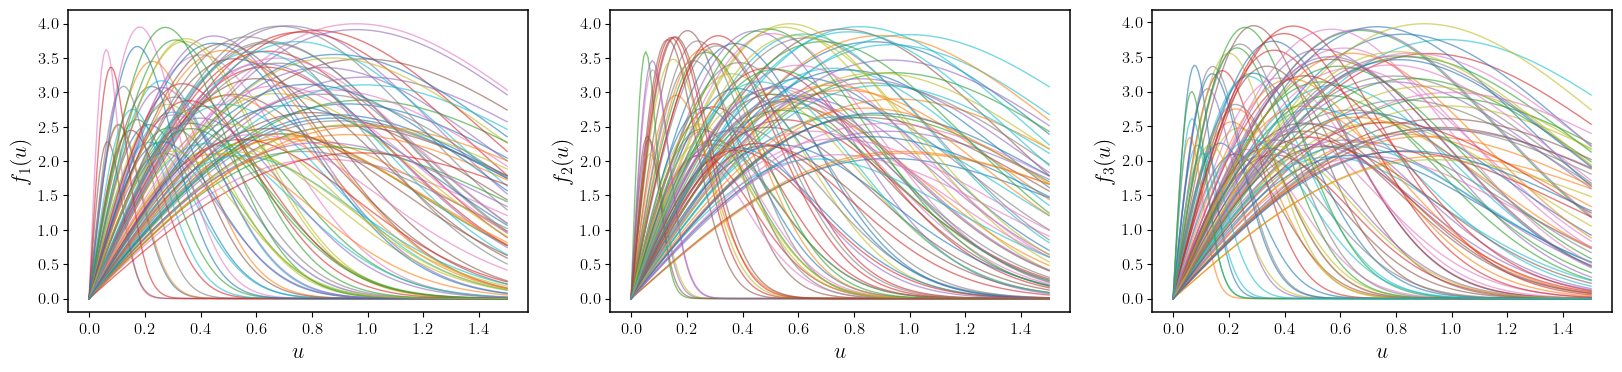

Saved input figures in: ./outputs/toy/figures


In [7]:
# Dimensions
dimF = 3
dim_task = 2

# Replicates
nrepTrain = 100
nrepTest  = 1
nrep = nrepTrain + nrepTest
idx_test = nrep - 1

# Grids
nu = 100
u = np.linspace(0, 1.5, nu)          # time grid for outputs / GP input
nu_inputs = 200
u_inputs = np.linspace(0, 1.5, nu_inputs)  # grid for functional covariates

# Encoding
inertia = 0.999
wavelet = "haar"

# Training
num_epochs = 200
lr = 0.02
weight_decay = 1e-5
patience = 10
min_delta = 1e-4

# Model params (your par_f)
par_f = np.repeat(200.0, dimF)

def drayleigh(x, sigma):
    return (x / sigma**2) * np.exp(-x**2 / (2 * sigma**2))

def make_rayleigh_inputs(u_inputs, nrep, dimF=3, amp_range=(2,4), sigma_range=(0.05,1.0), seed=0):
    rng = np.random.default_rng(seed)
    fu = np.zeros((dimF, nrep, len(u_inputs)))
    for d in range(dimF):
        for i in range(nrep):
            sigma = rng.uniform(*sigma_range)
            amp   = rng.uniform(*amp_range)
            f = drayleigh(u_inputs, sigma)
            f = amp * f / np.max(f)
            fu[d, i, :] = f
    return fu

fu = make_rayleigh_inputs(u_inputs, nrep, dimF=dimF, seed=880)
fu.shape
def plot_inputs(u_inputs, fu, fig_dir):
    dimF, nrep, _ = fu.shape

    fig, axes = plt.subplots(
        1, dimF, figsize=(5.5 * dimF, 4), sharey=False
    )

    # Si dimF = 1, axes n'est pas itérable
    if dimF == 1:
        axes = [axes]

    for d, ax in enumerate(axes):
        for i in range(nrep):
            ax.plot(u_inputs, fu[d, i, :], alpha=0.6, linewidth=1.0)

        ax.set_xlabel(r"$u$")
        ax.set_ylabel(fr"$f_{{{d+1}}}(u)$")
        ax.grid(False)

    fig.tight_layout()

    # sauvegarde
    fig.savefig(
        os.path.join(fig_dir, "toy_inputs_all.pdf"),
        bbox_inches="tight",
        dpi=300
    )

    # affichage dans Jupyter
    plt.show()
plot_inputs(u_inputs, fu, FIG_DIR)
print("Saved input figures in:", FIG_DIR)



We generate synthetic functional outputs by sampling realizations from a
multitask Gaussian process conditioned on the functional inputs
$\boldsymbol{\mathcal{F}}$ generated previously. The output process is defined through a **separable covariance structure**
combining:
(i) a task-level covariance encoding correlations between outputs,
(ii) a covariance over the functional input space, and
(iii) a covariance over the discretized grid $u$.
The resulting covariance operator is sampled efficiently using a Kronecker-based Cholesky factorization.



In [9]:
def mvrnorm_chol_kron(Ltask, Lf, Lu, seed=0):
    rng = np.random.default_rng(seed)
    S = Ltask.shape[0]
    nf = Lf.shape[0]
    nu = Lu.shape[0]
    v = rng.standard_normal(size=(S, nf, nu))
    v = (Ltask @ v.reshape(S, nf*nu)).reshape(S, nf, nu)
    v = Lf @ v @ Lu.T
    return v  # (S, nf, nu)

# Task correlation
corr_task = np.array([[1.0, 0.85],
                      [0.85, 1.0]])
Ltask = np.linalg.cholesky(corr_task)

# Covariance over u (time)
u_torch = torch.tensor(u, dtype=torch.float32).unsqueeze(-1)
kernel_u = CustomKernel()
cov_u = kernel_u(u_torch, u_torch).evaluate().detach().numpy()
Lu = np.linalg.cholesky(cov_u + 1e-5*np.eye(nu))

# Covariance over functional inputs (via PCA coefficients from sklearn PCA)
fu_coeff_pca = []
rng = np.random.default_rng(8495)
for d in range(dimF):
    pca = PCA(n_components=inertia, svd_solver="full")
    pca.fit(fu[d])                 # (nrep, nu_inputs)
    fu_coeff_pca.append(pca.transform(fu[d]))

cov_f = np.zeros((nrep, nrep))
for i in range(nrep):
    fi = [fu_coeff_pca[d][i] for d in range(dimF)]
    for j in range(nrep):
        fj = [fu_coeff_pca[d][j] for d in range(dimF)]
        dist2 = sum(np.sum((fi[d]-fj[d])**2 / par_f[d]**2) for d in range(dimF))
        cov_f[i, j] = (1 + np.sqrt(5*dist2) + 5*dist2/3) * np.exp(-np.sqrt(5*dist2))

Lf = np.linalg.cholesky(cov_f + 1e-5*np.eye(nrep))

# Sample outputs: (dim_task, nrep, nu)
ysamp = mvrnorm_chol_kron(Ltask, Lf, Lu, seed=48)
ysamp.shape


(2, 101, 100)

This construction yields correlated functional outputs
$y_1(\boldsymbol{\mathcal{F}}, u)$ and $y_2(\boldsymbol{\mathcal{F}}, u)$,
representative of the responses of a complex mechanical system.


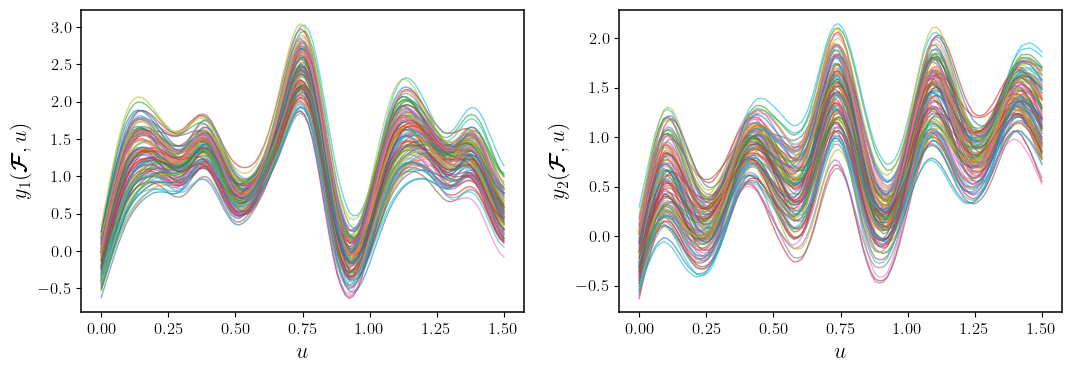

Saved output figures in: ./outputs/toy/figures


In [11]:
def plot_outputs(u, ysamp, fig_dir):
    S, nrep, _ = ysamp.shape

    fig, axes = plt.subplots(
        1, S, figsize=(5.5 * S, 4), sharey=False
    )

    
    if S == 1:
        axes = [axes]

    for s, ax in enumerate(axes):
        for i in range(nrep):
            ax.plot(u, ysamp[s, i, :], alpha=0.6, linewidth=1.0)

        ax.set_xlabel(r"$u$")
        ax.set_ylabel(fr"$y_{{{s+1}}}(\boldsymbol{{\mathcal{{F}}}}, u)$")
     
        ax.grid(False)

    fig.tight_layout()

    
    fig.savefig(
        os.path.join(fig_dir, "toy_outputs_all.pdf"),
        bbox_inches="tight",
        dpi=300
    )

   
    plt.show()
plot_outputs(u, ysamp, FIG_DIR)
print("Saved output figures in:", FIG_DIR)


### Dimensionality reduction for functional inputs

We encode the functional inputs using a PCA representation, retaining a total
inertia of $99.9\%$.
The resulting PCA scores are used to define distances between functional
replicates for the Gaussian process model.
For comparison, a Wavelet + PCA encoding with the same number of components
is also considered.


In [13]:
def pca_projection(M, inertia=0.999):
    C = np.cov(M.T)
    lam, vec = np.linalg.eigh(C)
    idx = np.argsort(lam)[::-1]
    lam, vec = lam[idx], vec[:, idx]
    k = np.searchsorted(np.cumsum(lam)/np.sum(lam), inertia) + 1
    return vec[:, :k]  # (nu_inputs, k)

def encode_pca(fu, idx_train, inertia=0.999):
    dimF, nrep, _ = fu.shape
    proj = [pca_projection(fu[d, idx_train, :], inertia=inertia) for d in range(dimF)]
    Z = [fu[d] @ proj[d] for d in range(dimF)]  # (nrep, k_d)
    n_comp = min(z.shape[1] for z in Z)
    Z = np.stack([z[:, :n_comp] for z in Z], axis=0)  # (dimF, nrep, n_comp)
    return Z, n_comp

def encode_wavelet_pca(fu, n_comp, wavelet="haar"):
    dimF, nrep, nu_inputs = fu.shape
    w = pywt.Wavelet(wavelet)
    level = pywt.dwt_max_level(nu_inputs, w.dec_len)
    Z_wave = []
    for d in range(dimF):
        coef_matrix = []
        for i in range(nrep):
            coeffs = pywt.wavedec(fu[d, i, :], wavelet, level=level)
            coef_matrix.append(np.hstack(coeffs))
        coef_matrix = np.vstack(coef_matrix)
        pca = PCA(n_components=n_comp)
        Z_wave.append(pca.fit_transform(coef_matrix))
    return np.asarray(Z_wave)

idx_train = [i for i in range(nrep) if i != idx_test]

Z_pca, n_comp = encode_pca(fu, idx_train, inertia=inertia)
Z_wave = encode_wavelet_pca(fu, n_comp=n_comp, wavelet=wavelet)

Z_pca.shape, Z_wave.shape, n_comp
def build_design(u, Z, idx_list):
    u = np.asarray(u).reshape(-1, 1)
    nu = u.shape[0]
    dimF, _, n_comp = Z.shape
    X = np.zeros((len(idx_list)*nu, 1 + dimF*n_comp), dtype=np.float32)

    row = 0
    for i in idx_list:
        feat = Z[:, i, :].reshape(1, -1)
        feat = np.repeat(feat, repeats=nu, axis=0)
        X[row:row+nu, :] = np.hstack([u, feat])
        row += nu

    return torch.tensor(X, dtype=torch.float32)

# Train/test for PCA encoding
train_x_pca = build_design(u, Z_pca, idx_train)
test_x_pca  = build_design(u, Z_pca, [idx_test])

# Train/test for Wavelet+PCA encoding
train_x_wave = build_design(u, Z_wave, idx_train)
test_x_wave  = build_design(u, Z_wave, [idx_test])

# Targets (same for both encodings)
y_train = ysamp[:, idx_train, :]                       # (S, ntrain, nu)
y_test  = ysamp[:, idx_test:idx_test+1, :]             # (S, 1, nu)

train_y = torch.tensor(y_train, dtype=torch.float32).permute(1,2,0).reshape(-1, dim_task)
test_y  = torch.tensor(y_test,  dtype=torch.float32).permute(1,2,0).squeeze(0).reshape(-1, dim_task)

train_x_pca.shape, train_y.shape, test_x_pca.shape, test_y.shape


(torch.Size([10000, 19]),
 torch.Size([10000, 2]),
 torch.Size([100, 19]),
 torch.Size([100, 2]))

The model is trained for a maximum of $200$ epochs using the Adam optimizer
with a learning rate of $0.02$ and an $\ell_2$ regularization weight of $10^{-5}$.
Early stopping is applied with a patience of $10$ epochs and a minimum
improvement threshold of $10^{-4}$ on the marginal log-likelihood.

In [15]:
def fit_mtgp(train_x, train_y, dim_task, par_f,
             num_epochs=200, lr=0.02, weight_decay=1e-5, patience=10, min_delta=1e-4):
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=dim_task)
    model = MultiTaskfunctional(
        train_x=train_x,
        train_y=train_y,
        likelihood=likelihood,
        num_tasks=dim_task,
        num_func_inputs=len(par_f),
        par_f=par_f,
    )

    model.train(); likelihood.train()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr, betas=(0.98,0.999), eps=1e-6,
        weight_decay=weight_decay, amsgrad=True
    )
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    best_loss = float("inf")
    best_state = deepcopy(model.state_dict())
    patience_counter = 0

    for epoch in range(num_epochs):
        optimizer.zero_grad(set_to_none=True)
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

        cur = float(loss.item())
        if cur < best_loss - min_delta:
            best_loss = cur
            best_state = deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model.load_state_dict(best_state)
    model.eval(); likelihood.eval()
    return model, likelihood

@torch.no_grad()
def predict_mtgp(model, likelihood, test_x):
    obs = likelihood(model(test_x))
    return obs.mean, obs.variance.sqrt()


Model performance is assessed using three complementary criteria, computed
separately for each output task.
The $Q^2$ coefficient measures predictive accuracy relative to the empirical
variance of the outputs.
The root mean squared error (RMSE) quantifies the average prediction error.
Finally, the empirical coverage (CA) quantifies the proportion of true values
lying within the $\pm 1.96\,\sigma$ predictive interval.


In [17]:
def q2_per_task(y_true, y_pred):
    y_bar = torch.mean(y_true, dim=0, keepdim=True)
    ss_res = torch.sum((y_true - y_pred) ** 2, dim=0)
    ss_tot = torch.sum((y_true - y_bar) ** 2, dim=0)
    return 1.0 - ss_res/ss_tot

def rmse_per_task(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred)**2, dim=0))

def coverage_per_task(y_true, y_pred, y_std, c=1.96):
    within = torch.abs(y_true - y_pred) <= c*y_std
    return within.float().mean(dim=0)


In [19]:
model_pca, lik_pca = fit_mtgp(
    train_x_pca, train_y, dim_task, par_f,
    num_epochs=num_epochs, lr=lr, weight_decay=weight_decay,
    patience=patience, min_delta=min_delta
)
pred_mean_pca, pred_std_pca = predict_mtgp(model_pca, lik_pca, test_x_pca)

print("RMSE:", rmse_per_task(test_y, pred_mean_pca).numpy())
print("Q2  :", q2_per_task(test_y, pred_mean_pca).numpy())
print("CA95:", coverage_per_task(test_y, pred_mean_pca, pred_std_pca).numpy())


RMSE: [0.0092695  0.02086555]
Q2  : [0.99974185 0.99793965]
CA95: [1. 1.]


In [21]:
model_wav, lik_wav = fit_mtgp(
    train_x_wave, train_y, dim_task, par_f,
    num_epochs=num_epochs, lr=lr, weight_decay=weight_decay,
    patience=patience, min_delta=min_delta
)
pred_mean_wav, pred_std_wav = predict_mtgp(model_wav, lik_wav, test_x_wave)

print("RMSE:", rmse_per_task(test_y, pred_mean_wav).numpy())
print("Q2  :", q2_per_task(test_y, pred_mean_wav).numpy())
print("CA95:", coverage_per_task(test_y, pred_mean_wav, pred_std_wav).numpy())


RMSE: [0.00962917 0.01919431]
Q2  : [0.99972147 0.99825644]
CA95: [1. 1.]


### Prediction results and uncertainty quantification


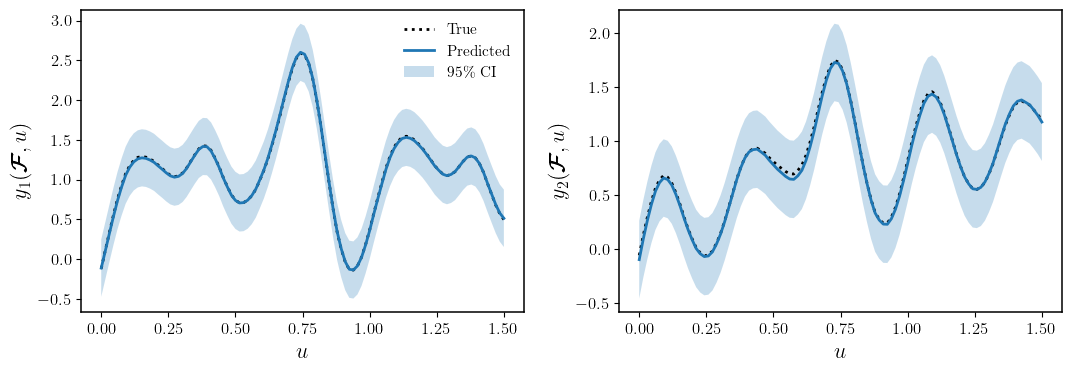

Saved prediction plots in: ./outputs/toy/figures


In [23]:
def plot_prediction(u, y_true, y_pred, y_std, q2_vals, fname):
    u = np.asarray(u)

    fig, axes = plt.subplots(1, y_true.shape[1],
                             figsize=(5.5 * y_true.shape[1], 4))

    # cas dim_task = 1
    if y_true.shape[1] == 1:
        axes = [axes]

    for task, ax in enumerate(axes):
        yt = y_true[:, task].detach().cpu().numpy()
        yp = y_pred[:, task].detach().cpu().numpy()
        sd = y_std[:, task].detach().cpu().numpy()

        ax.plot(u, yt, "k:", lw=2.0, label="True")
        ax.plot(u, yp, lw=2.0, label="Predicted")
        ax.fill_between(
            u,
            yp - 1.96 * sd,
            yp + 1.96 * sd,
            alpha=0.25,
            label=r"$95\%$ CI"
        )

        ax.set_xlabel(r"$u$")
        ax.set_ylabel(fr"$y_{{{task+1}}}(\boldsymbol{{\mathcal{{F}}}}, u)$")

        ax.grid(False)

        if task == 0:
            ax.legend(frameon=False)

    fig.tight_layout()

    # sauvegarde
    fig.savefig(fname, bbox_inches="tight", dpi=300)

    # affichage dans Jupyter
    plt.show()
q2_vals = q2_per_task(test_y, pred_mean_pca)

plot_prediction(
    u,
    test_y,
    pred_mean_pca,
    pred_std_pca,
    q2_vals,
    os.path.join(FIG_DIR, "pred_pca_y1_y2.pdf")
)

print("Saved prediction plots in:", FIG_DIR)
